# Forever Monsterous:  A Kung Faux Pandas Tutorial

Kung Faux Pandas (KFP) is a set of tools which extends the [Pandas](https://pandas.pydata.org/ "Pandas Homepage") dataframe to include some tools for generating synthetic data.

There are many reasons to create synthetic data, but KFP assumes the reason is to give a statistical analyst "realistic" data, which we term _faux_ data, without exposing the real dataset.   
Details on the tools and how to install them are available on the [KFP github repository] (https://github.com/CUD2V/kungfauxpandas).

This tutorial assumes you have installed KFP as well as some standard data science tools, such as numpy, scipy, and matplotlib.

## Chapter 1:  The Problem

Monsters are a tricky lot.   They have widely varying statistics and capabilities and many have spent centuries building up their reputations in order to disuade adventurers from invading their spaces.  The smarter variety of monsters have consistently retained good lawyers through the ages, and it in most jurisdictions it's actually illegal to publish the "personal" data any monster.

Of course, we would like to study the monsters without violating their privacy rights.   KFP can help this problem!

1. Generate a fake data set based on the real stuff
2. Work out all steps necessary to clean the data up
3. Code the data cleaning steps into a function
4. Re-run the data generation using the data cleaner
5. Get a clean, synthetic data set to study
6. Have a trusted agent (DM?) run your study code on the real data and deliver you the results.



In [1]:
import sqlite3
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import pylab as plt
from collections import Counter
import datetime
import sys
sys.path.append('../')
sys.path.append('../../../plugins/DataSynthesizer/DataSynthesizer/')
sys.path.append('../../../plugins/DataSynthesizer/')
from importlib import reload
from kungfauxpandas import KungFauxPandas, TrivialPlugin, DataSynthesizerPlugin, KDEPlugin
from fractions import Fraction
%matplotlib inline

# Step 0:  Get the real data
In the real scenario, this step would be done in a secure computing environment to which the researcher has no access.

In [2]:
# Data from: https://docs.google.com/spreadsheets/d/16ajgJpvUI0wYcSU7kjHutw8oB6Zv6eIAo5JtI6PLvu8/edit#gid=776794522
monsterfile = "../../../data/D&D 5e Monster List with Ability Scores.xlsx - Monsters by Ability Score.csv"
df = pd.read_csv(monsterfile)
df.sample(10)

,Name,Type,ALIGNMENT,Size,CR,AC,HP,STR,DEX,CON,INT,WIS,CHA
376,Cloud Giant,Giant,N,Huge,9,14,200,27,10,22,12,16,16.0
595,Adult Kruthik,Monstrosity,U,Medium,2,18,39,15,16,15,7,12,8.0
187,"Bronze Dragon, Ancient",Dragon,LG,Gargantuan,22,22,444,29,10,27,18,17,21.0
637,Thorny,Plant,N,Medium,1,14,27,13,12,13,2,10,6.0
45,Elephant,Beast,U,Huge,4,12,76,22,9,17,3,11,6.0
597,Carrion Crawler,Monstrosity,U,Large,2,13,51,14,13,16,1,12,5.0
289,Hydroloth,Fiend,NE,Medium,9,15,135,12,21,16,19,10,14.0
418,War Priest,Humanoid,ANY,Medium,9,18,117,16,10,14,11,17,13.0
516,Orc Nurtured One of Yurtrus,Humanoid,CE,Medium,1/2,9,30,15,8,16,7,11,7.0
314,Goristro,Fiend (Demon),CE,Huge,17,19,310,25,11,25,6,13,14.0


## Step 1: Grab round 1 of the fake data

In [3]:
# Instantiate KFP object
kfpd = KungFauxPandas(plugin=KDEPlugin(),
                      logging='../../../data/kfp_log.db',
                      db_file='../../../data/monsters.db')

# Ensure KFP object has the options we want
kfpd.plugin.capture_covariance = True
kfpd.plugin.determine_factors =  True

# Generate the Fake data
kfpd.plugin.fauxify(df_in=df)

# Do some renames to improve readability
faux_df = kfpd.plugin.df_out
factor_indices = kfpd.plugin.factor_indices


Preprocess None
Building KDE Model


# Step 2: EDA and Data Cleanup

In [4]:
faux_df.sample(5)

,Type,ALIGNMENT,Size,CR,AC,HP,STR,DEX,CON,INT,WIS,CHA
418,1.059753,7.033672,3.981787,16.965493,9.983326,0.990464,1.988472,11.041203,9.028838,2.010031,10.034255,4.020048
371,14.044071,4.008534,0.966237,11.018127,15.003323,74.783926,18.050155,10.022315,14.982374,6.069961,12.038335,7.041281
74,12.993474,0.995189,3.021833,11.983459,12.973972,47.545542,6.949638,15.983722,14.953299,9.929959,10.950610,11.946950
221,14.055771,3.995570,-0.027995,12.022474,12.055382,59.334986,17.041374,12.017493,15.056232,5.140403,13.045185,8.130676
57,0.969588,7.062867,0.999705,12.981905,13.989919,26.759079,14.051135,15.999280,12.020118,2.007933,11.045520,4.056531


Since we seleccted the KDE plugin, this data was generated with a Gaussian Kernel Density Estimator, which assumes that the samples come from a continuous distribution.   That is, numbers like Hit Points (HP) are assumed to take any decimal value.    Due to our domain expertise, however, we know that these numbers really should all be integers.    One could generate a more complex simulation model or just round off our fake data.   

In [5]:
# Get numbers back to integers
faux_df = faux_df.round().astype('int')
faux_df.sample(5)

,Type,ALIGNMENT,Size,CR,AC,HP,STR,DEX,CON,INT,WIS,CHA
152,4,6,5,26,19,256,27,14,25,16,15,24
365,4,6,5,0,19,245,27,10,25,16,13,21
253,14,7,1,9,17,94,19,11,21,2,10,5
336,4,6,0,12,17,32,17,10,15,12,11,15
409,8,0,0,15,11,18,9,12,11,5,8,5


These look more like we might expect, however some of our fields were factors (i.e. text fields).  We'd like to restore these to their original labels.

In [6]:
# Back-transform factors to their labels
for factor_name in factor_indices:
    alt = factor_indices[factor_name]
    altlab = np.arange(len(alt))
    lookup = dict(zip(altlab,alt))
    faux_df[factor_name]=[lookup[xx] for xx in faux_df[factor_name]]

faux_df.sample(5)

,Type,ALIGNMENT,Size,CR,AC,HP,STR,DEX,CON,INT,WIS,CHA
91,Humanoid,NOT GOOD,Medium,8,18,151,18,11,18,11,14,15
591,Undead,NE,Large,5,15,94,10,8,16,3,8,5
341,Fiend (Demon),CE,Medium,3,14,53,15,14,17,8,9,6
543,Beast,U,Tiny,0,10,0,2,11,10,1,8,3
319,Beast,U,Large,1,14,26,14,16,12,2,11,4


This looks much more like what we'd expect.    Lets do some exploration and cleaning.

In [7]:
distincts = faux_df.Type.unique()
print(distincts)
distincts.sort()
print(distincts)


['Humanoid' 'Monstrosity' 'Fey' 'Fiend (Devil)' 'Fiend (Demon)' 'Beast'
 'Elemental' 'Construct' 'Giant ' 'Giant' 'Undead' 'Fiend' 'Aberration'
 'Dragon' 'Celestial' 'Ooze' 'Plant' 'Fiend (demon)']
['Aberration' 'Beast' 'Celestial' 'Construct' 'Dragon' 'Elemental' 'Fey'
 'Fiend' 'Fiend (Demon)' 'Fiend (Devil)' 'Fiend (demon)' 'Giant' 'Giant '
 'Humanoid' 'Monstrosity' 'Ooze' 'Plant' 'Undead']


+ **Boo!  Why is Giant in there twice? A trailing space!**

Lets check the other factors.

In [8]:
distincts = faux_df.Size.unique()
print(distincts)
distincts.sort()
print(distincts)

['Medium' 'Huge' 'Tiny' 'Large' 'Small' 'small' 'Gargantuan' 'VARIES'
 'large']
['Gargantuan' 'Huge' 'Large' 'Medium' 'Small' 'Tiny' 'VARIES' 'large'
 'small']


+ **ooh!  There's "large" and "Large", "small and "Small", and "VARIES" changes capitalization convention.**

In [9]:
distincts = faux_df.ALIGNMENT.unique()
print(distincts)
distincts.sort()
print(distincts)



['ANY' 'CE' 'N' 'CN' 'LE' 'LN' 'U' 'NE' 'C' 'ANY EVIL' 'CG' 'LG' 'NOT GOOD'
 'NOT LAWFUL' 'NG' 'E' 'CG OR NE']
['ANY' 'ANY EVIL' 'C' 'CE' 'CG' 'CG OR NE' 'CN' 'E' 'LE' 'LG' 'LN' 'N' 'NE'
 'NG' 'NOT GOOD' 'NOT LAWFUL' 'U']


* **No problems jump out here**

In [10]:
distincts = faux_df.CR.unique()
print(distincts)
distincts.sort()
print(distincts)

['1' '9' '11' '10' '3' '1/4' '1/2' '4' '25' '7' '13' '6' '2' '5' '0' '1/8'
 '17' '12' '16' '23' '15' '8' '21' '18' '26' '22' '20' '19' '14' '24' '30']
['0' '1' '1/2' '1/4' '1/8' '10' '11' '12' '13' '14' '15' '16' '17' '18'
 '19' '2' '20' '21' '22' '23' '24' '25' '26' '3' '30' '4' '5' '6' '7' '8'
 '9']


*  **This has numbers, mostly.  There's a '-' for some reason.   Also, there are fractions which we might want to be numerical.**

Lets build a preprocessor that can fix these problems for us.  

In [11]:
# Preprocessing instructions
def df_preprocess(df):

    # Get rid of rows with missing data
    df=df.dropna()
    
    # Take care of capitalization problems
    df['Size']=pd.Series([xx.capitalize().strip() for xx in df.Size])
    df['Type']=pd.Series([xx.capitalize().strip() for xx in df.Type])
    df['ALIGNMENT'] = pd.Series([xx.upper().strip() for xx in df.ALIGNMENT])
    
    # Convert any '-' values to a 0
    #df['CR'] = pd.Series([xx if xx is not '-' else '0' for xx in df.CR])
    df['CR'] = pd.Series([float(Fraction(xx)) if xx is not '-' else 0.0 for xx in df.CR])
    return(df)

Lets verify that df_preprocess seems to fix our problems on our original data set.

In [14]:
fixed = df_preprocess(faux_df)
print(fixed.Size.unique(), '\n\n', fixed.Type.unique(),'\n\n',fixed.ALIGNMENT.unique())

print(fixed.CR.unique())

['Medium' 'Huge' 'Tiny' 'Large' 'Small' 'Gargantuan' 'Varies'] 

 ['Humanoid' 'Monstrosity' 'Fey' 'Fiend (devil)' 'Fiend (demon)' 'Beast'
 'Elemental' 'Construct' 'Giant' 'Undead' 'Fiend' 'Aberration' 'Dragon'
 'Celestial' 'Ooze' 'Plant'] 

 ['ANY' 'CE' 'N' 'CN' 'LE' 'LN' 'U' 'NE' 'C' 'ANY EVIL' 'CG' 'LG' 'NOT GOOD'
 'NOT LAWFUL' 'NG' 'E' 'CG OR NE']
[  1.      9.     11.     10.      3.      0.25    0.5     4.     25.      7.
  13.      6.      2.      5.      0.      0.125  17.     12.     16.     23.
  15.      8.     21.     18.     26.     22.     20.     19.     14.     24.
  30.   ]


Ok.  Lets re-run with the preprocessor!

In [22]:
# Instantiate KFP object
kfpd = KungFauxPandas(plugin=KDEPlugin(),
                      logging='../../../data/kfp_log.db',
                      db_file='../../../data/monsters.db')

# Ensure KFP object has the options we want
kfpd.plugin.capture_covariance = True
kfpd.plugin.determine_factors =  True

# Generate the Fake data
kfpd.plugin.fauxify(df_in=df, preprocess=df_preprocess)

# Do some renames to improve readability
faux_df = kfpd.plugin.df_out
factor_indices = kfpd.plugin.factor_indices

Preprocess <function df_preprocess at 0x10fffb598>
Building KDE Model


/Users/jamesking/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jamesking/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/jamesking/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [23]:
# Get numbers back to integers
faux_df = faux_df.round().astype('int')

In [24]:
faux_df.sample(10)

,Type,ALIGNMENT,Size,CR,AC,HP,STR,DEX,CON,INT,WIS,CHA
144,11,14,0,2,12,30,12,11,16,11,14,9
280,7,2,1,9,17,145,19,14,21,16,15,18
277,4,0,0,2,14,52,16,11,16,4,10,7
506,12,5,1,21,18,472,30,11,25,22,18,20
86,1,7,2,5,15,121,21,9,17,2,10,7
36,11,0,0,2,15,31,14,16,15,14,15,11
404,12,2,5,12,19,190,19,13,20,3,6,8
549,15,1,1,15,17,96,18,10,17,11,18,16
258,1,7,0,0,12,13,10,14,10,1,10,3
554,4,6,1,13,18,177,23,10,21,14,11,19


In [25]:
factor_indices

{'ALIGNMENT': Index(['CE', 'LE', 'NE', 'CN', 'N', 'LN', 'LG', 'U', 'CG OR NE', 'CG',
        'SAME AS EIDOLON', 'NG', 'E', 'C', 'ANY', 'NOT GOOD', 'NOT LAWFUL',
        'ANY EVIL'],
       dtype='object'),
 'Size': Index(['Medium', 'Large', 'Gargantuan', 'Small', 'Tiny', 'Huge', 'Varies'], dtype='object'),
 'Type': Index(['Aberration', 'Beast', 'Celestial', 'Construct', 'Dragon', 'Elemental',
        'Fey', 'Fiend', 'Fiend (demon)', 'Fiend (devil)', 'Giant', 'Humanoid',
        'Monstrosity', 'Ooze', 'Plant', 'Undead'],
       dtype='object')}

In [26]:
# Back-transform factors to their labels
for factor_name in factor_indices:
    alt = factor_indices[factor_name]
    altlab = np.arange(len(alt))
    lookup = dict(zip(altlab,alt))
    faux_df[factor_name]=[lookup[xx] for xx in faux_df[factor_name]]



In [98]:
faux_df.sample(5)

,Type,ALIGNMENT,Size,CR,AC,HP,STR,DEX,CON,INT,WIS,CHA
638,Beast,U,Huge,2,12,60,19,14,12,1,10,3
561,Giant,CN,Huge,12,16,229,29,14,20,16,18,18
111,Monstrosity,NE,Medium,2,13,34,16,12,13,9,12,10
385,Humanoid,NE,Medium,18,17,261,12,18,16,17,21,22
77,Beast,U,Large,0,12,19,13,15,12,8,13,10


# Comparing the Faux Data to the Original

## Faux Data

In [97]:
import statsmodels.api as sm
from fractions import Fraction
import numpy
#reg = linear_model.LinearRegression()

y = [float(Fraction(xx))  if xx !='-' else 0.0 for xx in faux_df.CR]
#X = faux_df.iloc[:,[xx in ['HP','AC','STR','DEX','INT','CON','WIS'] for xx in faux_df.columns]]
X = faux_df.iloc[:,[xx in ['HP','STR','DEX','WIS'] for xx in faux_df.columns]]
#X = sm.add_constant(X)  

M1 = sm.OLS(y,X)
print(M1.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     1071.
Date:                Wed, 29 Aug 2018   Prob (F-statistic):          3.29e-293
Time:                        13:59:25   Log-Likelihood:                -1771.8
No. Observations:                 690   AIC:                             3552.
Df Residuals:                     686   BIC:                             3570.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HP             0.0551      0.002     30.796      0.0

## Real Data

In [104]:
import statsmodels.api as sm
from fractions import Fraction
import numpy
#reg = linear_model.LinearRegression()

y2 = [float(Fraction(xx))  if xx !='-' else 0 for xx in df.CR]
#X2 = df.iloc[:,[xx in ['HP','AC','STR','DEX','INT','CON','WIS'] for xx in df.columns]]
X2 = df.iloc[:,[xx in ['HP','STR','WIS'] for xx in df.columns]]

#X2 = sm.add_constant(X2)  
X2.columns

M2 = sm.OLS(y2,X2)
print(M2.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3064.
Date:                Wed, 29 Aug 2018   Prob (F-statistic):               0.00
Time:                        19:39:54   Log-Likelihood:                -1522.9
No. Observations:                 691   AIC:                             3052.
Df Residuals:                     688   BIC:                             3065.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HP             0.0629      0.001     52.289      0.0

(array([ 300.,  144.,   71.,   63.,   42.,   28.,   13.,   21.,    8.,    1.]),
 array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.]),
 <a list of 10 Patch objects>)

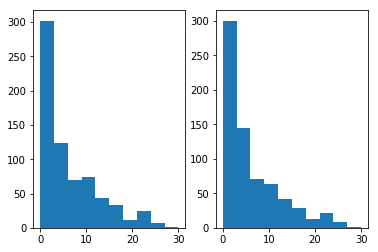

In [78]:
%matplotlib inline
plt.subplot(1,2,1)
plt.hist(y)
plt.subplot(1,2,2)
plt.hist(y2)

array([[ 39.29158749,  -3.51282745],
       [ -3.51282745,  11.52846326]])

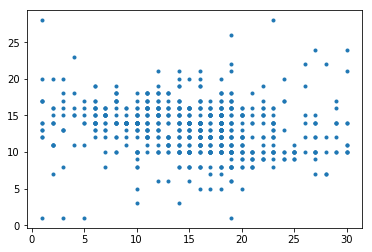

In [91]:
plt.plot(df['STR'],df['DEX'],'.')
np.cov(df['STR'],df['DEX'],'.')

In [170]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha = 0.1)
reg.fit(X, y)

#reg.predict([np.array(X_pred)])


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [179]:
val = 33
X_pred = fauxriginal.iloc[:,[xx in ['HP','AC','INT','CON'] for xx in df.columns]]
y_correct = y[:]
preds=reg.predict(np.array(X_pred))

In [186]:
av_err=np.mean(preds.round()-y_correct)

Exception: Input data frame not defined

In [8]:
help(BaseException)

Help on class BaseException in module builtins:

class BaseException(object)
 |  Common base class for all exceptions
 |  
 |  Methods defined here:
 |  
 |  __delattr__(self, name, /)
 |      Implement delattr(self, name).
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __reduce__(...)
 |      helper for pickle
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  __setattr__(self, name, value, /)
 |      Implement setattr(self, name, value).
 |  
 |  __setstate__(...)
 |  
 |  __str__(self, /)
 |      Return str(self).
 |  
 |  with_traceback(...)
 |      Exception.with_traceback(tb) --
 |      set self.__traceback__ to tb and return self.
 |  
 |  ----------------------------------------------